In [1]:
import os.path as op
import shutil

import mne
from mne.datasets import eegbci

from mne_bids import write_raw_bids, BIDSPath, print_dir_tree
from mne_bids.stats import count_events

In [2]:
# get MNE directory with example data
# mne_data_dir = mne.get_config('MNE_DATASETS_EEGBCI_PATH')
# data_dir = op.join(mne_data_dir, 'MNE-eegbci-data')
data_dir = '/mnt/z/Projects/2023_Scholte_FMG1441/Data'
# print_dir_tree(data_dir)

In [8]:
all_epochs = {}
for sub in range(5, 36):
    eeg_dir = f'/mnt/z/Projects/2023_Scholte_FMG1441/Data/sub_{sub}/Preprocessed epochs/sub_{sub}-OC&CSD-AutoReject-epo.fif'

    all_epochs[sub] = mne.read_epochs(fname=eeg_dir, preload=True)

Reading /mnt/z/Projects/2023_Scholte_FMG1441/Data/sub_5/Preprocessed epochs/sub_5-OC&CSD-AutoReject-epo.fif ...


# EEG Plots

In [5]:
sub = 12

eeg_dir = f'/home/nmuller/projects/data/oads_eeg/sub_{sub}/sub_{sub}-OC&CSD-AutoReject-epo.fif'

epochs = mne.read_epochs(fname=eeg_dir, preload=True)

Reading /home/nmuller/projects/data/oads_eeg/sub_12/sub_12-OC&CSD-AutoReject-epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     400.39 ms
        0 CTF compensation matrices available
Not setting metadata
3983 matching events found
No baseline correction applied
0 projection items activated


In [11]:
import matplotlib.pyplot as plt

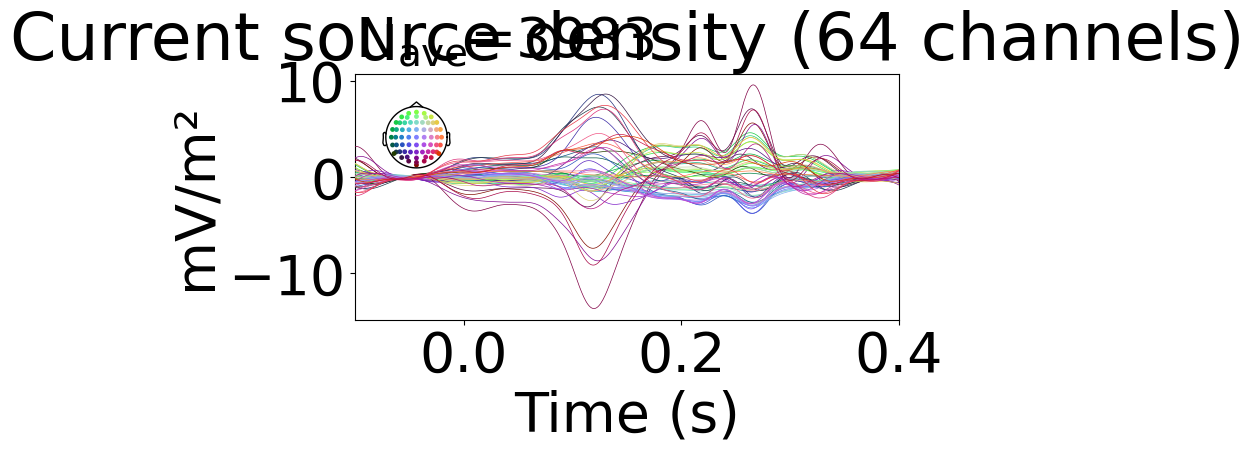

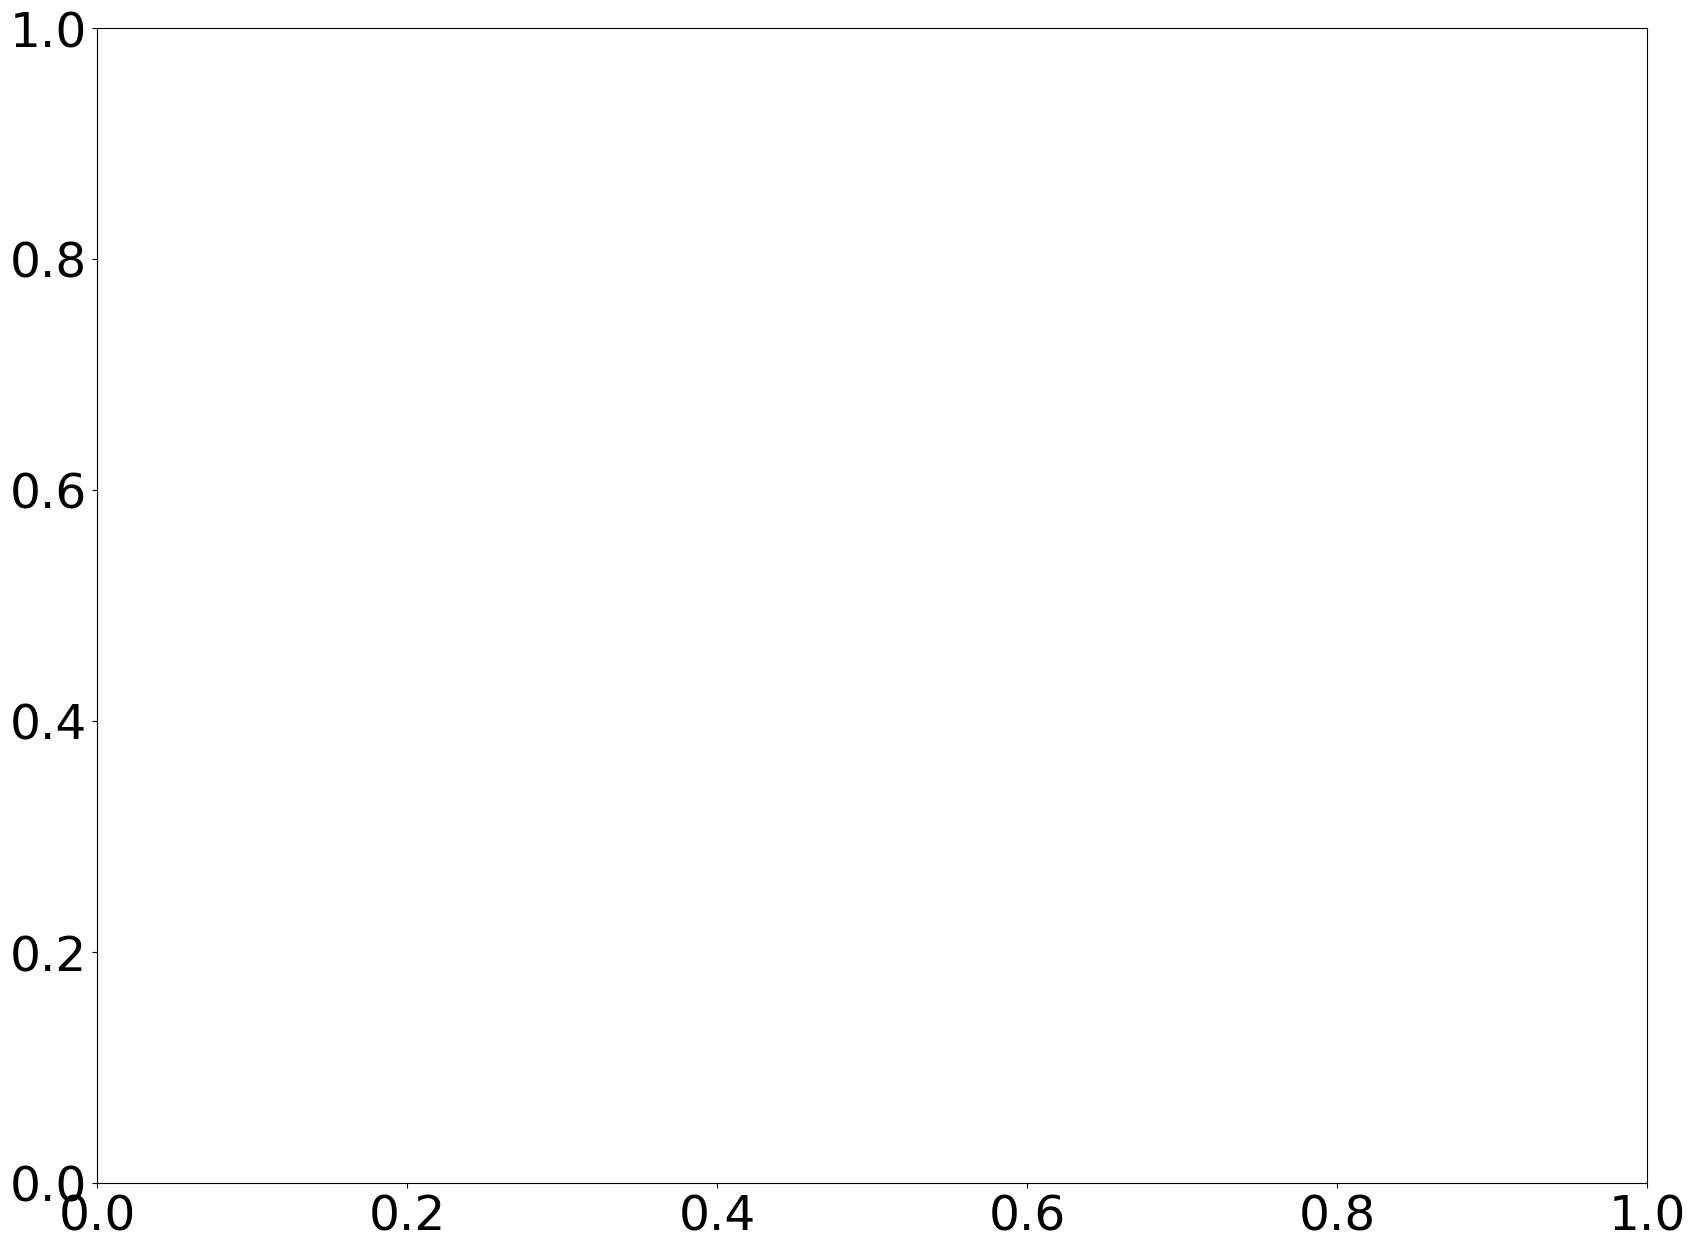

In [79]:
fig = epochs.average().plot()
font = {'size'   : 40}
plt.rc('font', **font)
plt.rc('legend', fontsize=35)


plt.setp(fig.axes[0].get_lines(), linewidth=3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.axes[0].set_title('64 channels', fontsize=40)
fig.axes[0].set_ylabel('')
fig.axes[0].set_xlabel('Time (s)', fontsize=35)
fig.set_dpi(300)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
# fig.axes[0].spines['left'].set_visible(False)
# fig.axes[0].spines['bottom'].set_visible(False)
# fig.axes[0].get_xaxis().set_visible(False)
# fig.axes[0].get_yaxis().set_visible(False)
fig.savefig(dpi=300, fname=f'sub_{sub}_epochs_transparent.png', transparent=True)
fig.savefig(dpi=300, fname=f'sub_{sub}_epochs.png', transparent=False)